# สร้างcappi ตามระดับความสูงที่ต้องการช่วงเวลาเดียว
* ปรับแก้ SNR
* ปรับแก้ attenuation


* ใช้ activate ml_nl_n1
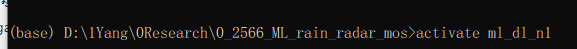


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyart
#import sys


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
radar = pyart.io.read_uf('../0data/0radar/0test_phs/PHI2018072112001a.uf') #พิษณุโลก
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio'])


# หาค่า signal to noise ratio  แล้วแอดฟิวด์

In [3]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field='reflectivity',toa=15000.0) #15000 ทดลองเอง
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)

In [1]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet',
                 title='Raw Reflectivity')
                 #title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('signal_to_noise_ratio', 0, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', ax=ax2,
                 title='signal_to_noise_ratio')

plt.suptitle('Comparing reflectivity vs signal_to_noise_ratio', fontsize=16)
plt.show()

NameError: name 'plt' is not defined

# กรองสัญญาณรบกวน ด้วยการใช้ SNR ใช้ gatefilter

In [5]:
gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar, phi_field='differential_phase')
gtfilter.exclude_below('signal_to_noise_ratio', 1) #ใช้ค่า snr  = 10 
#gtfilter.exclude_above('signal_to_noise_ratio', 70) #ใช้ค่า snr  = 60 
radar.add_field_like('reflectivity', 'reflectivity_copy',
                     radar.fields['reflectivity']['data'].copy())
nf = radar.fields['reflectivity_copy']
nf['data'] = np.ma.masked_where(gtfilter.gate_excluded , nf['data'])
radar.add_field('filtered_reflectivity', nf, replace_existing=True)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'signal_to_noise_ratio', 'reflectivity_copy', 'filtered_reflectivity'])


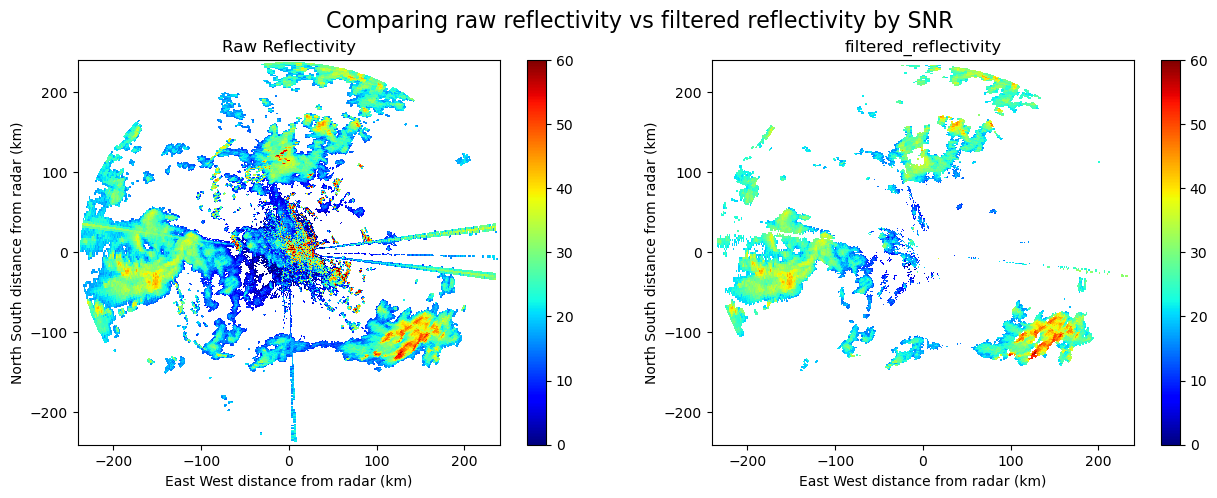

In [6]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet',
                 title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('filtered_reflectivity', 0, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', ax=ax2,
                 title='filtered_reflectivity')

plt.suptitle('Comparing raw reflectivity vs filtered reflectivity by SNR', fontsize=16)
plt.show()

# ปรับแก้ attnuation
* โค้ด https://arm-doe.github.io/pyart/examples/correct/plot_attenuation.html
* โค้ด https://openradarscience.org/erad2022/notebooks/pyart/exercice1_swiss_thunderstorm.html

## คำนวณฟิวด์ normalized coherent power NCP ขึ้นมาใหม่
* โค้ด https://github.com/ARM-DOE/pyart/issues/1202

In [7]:
ncp_values = np.ones((radar.nrays, radar.ngates))
ncp = pyart.config.get_metadata('normalized_coherent_power')
ncp['data'] = ncp_values
radar.add_field('normalized_coherent_power', ncp)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'signal_to_noise_ratio', 'reflectivity_copy', 'filtered_reflectivity', 'normalized_coherent_power'])


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\graph\radarmapdisplay.py:279: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


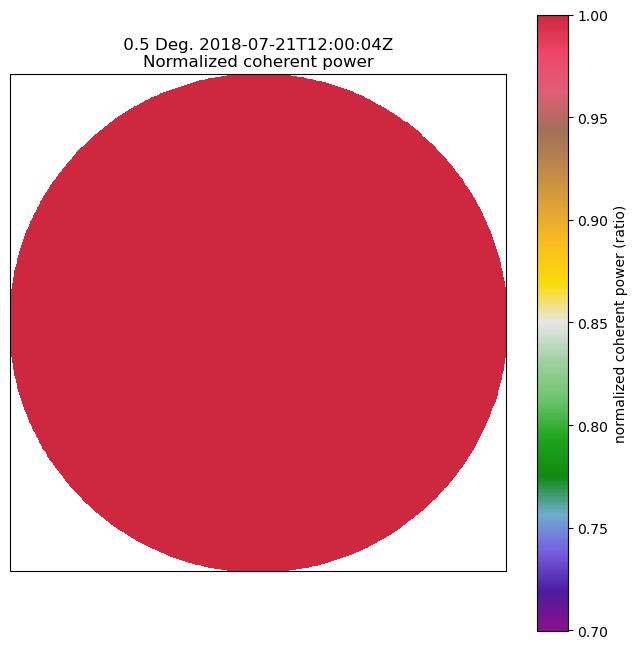

In [8]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('normalized_coherent_power', sweep=0, vmin=0.7, vmax=1.0)
plt.show()

##  ปรับแก้ attenuation correction 
* โค้ด จาก https://arm-doe.github.io/pyart/examples/correct/plot_attenuation.html
* โค้ดประมวลผล PhiDP https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html

In [9]:
#activate pyart # จะใช้ในการคำนวณ PhiDP ได้ เพราะหา glpk เจอ

In [10]:
import sys
sys.path.append(r'C:\Users\Admin\anaconda3\envs\ml_dl\lib\site-packages')

In [11]:
import glpk
glpk.__file__

'C:\\Users\\Admin\\anaconda3\\envs\\ml_dl_n1\\lib\\site-packages\\glpk.cp310-win_amd64.pyd'

In [12]:
# ปรับแก้ค่า phidp ก่อน เพื่อให้ได้ค่า proc_dp_phase_shift ที่จะนำไปใช้ในการปรับแก้ attenuation
phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, LP_solver='pyglpk',debug=True)
radar.add_field('proc_dp_phase_shift', phidp)
radar.add_field('recalculated_diff_phase', kdp)

Unfolding


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise


Exec time:  1.5284101963043213
Doing  0
Doing  1
Doing  2
Doing  3


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


In [13]:
# ปรับแก้ attenuation correction โค้ด จาก https://arm-doe.github.io/pyart/examples/correct/plot_attenuation.html
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar,
    0,
    fzl=4500.0,
    refl_field="filtered_reflectivity",
    ncp_field="normalized_coherent_power",
    rhv_field="cross_correlation_ratio",
    phidp_field="proc_dp_phase_shift",
)
radar.add_field("specific_attenuation", spec_at)
radar.add_field("corrected_filtered_reflectivity", cor_z)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'signal_to_noise_ratio', 'reflectivity_copy', 'filtered_reflectivity', 'normalized_coherent_power', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_filtered_reflectivity'])


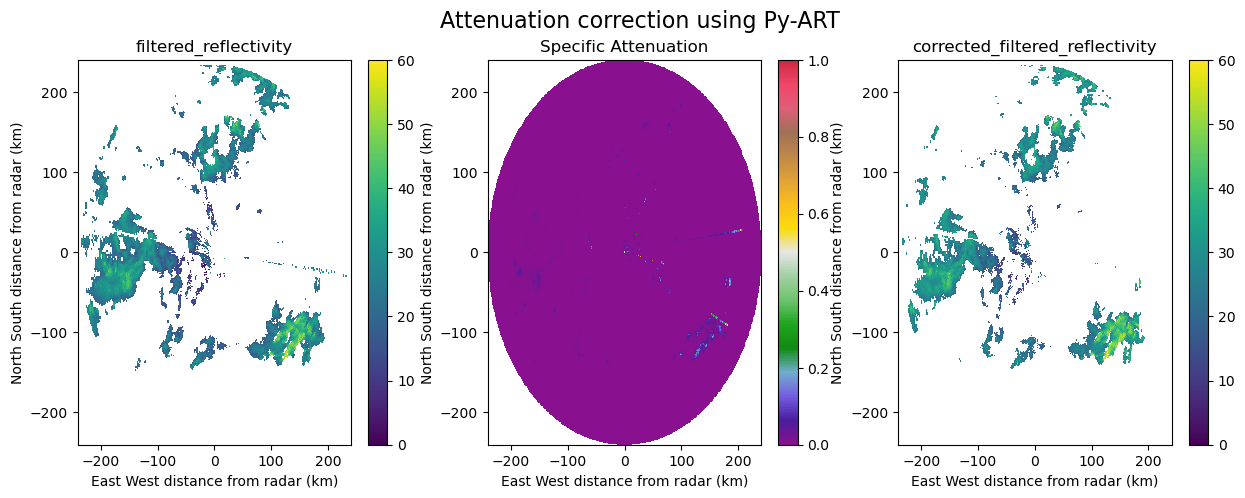

In [14]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
display = pyart.graph.RadarDisplay(radar)
display.plot(
    "filtered_reflectivity",
    0,
    ax=ax1,
    vmin=0,
    vmax=60.0,
    colorbar_label="",
    title="filtered_reflectivity",
)

ax2 = fig.add_subplot(132)
display.plot(
    "specific_attenuation",
    0,
    vmin=0,
    vmax=1.0,
    colorbar_label="",
    ax=ax2,
    title="Specific Attenuation",
)

ax3 = fig.add_subplot(133)
display = pyart.graph.RadarDisplay(radar)
display.plot(
    "corrected_filtered_reflectivity",
    0,
    vmin=0,
    vmax=60.0,
    colorbar_label="",
    ax=ax3,
    title="corrected_filtered_reflectivity",
)

plt.suptitle("Attenuation correction using Py-ART", fontsize=16)
plt.show()

* ซ้ายกับขวา ก่อนปรับกับหลังปรับ attenuation มีความแตกต่างกันพอสมควรเลย
* ให้ save corrected_filtered_reflectivity หลังทำกริดแล้ว ออกไปเทียบกับ filtered_reflectivity ใน QGIS

## ตรวจสอบผลการปรับแก้ attenuation

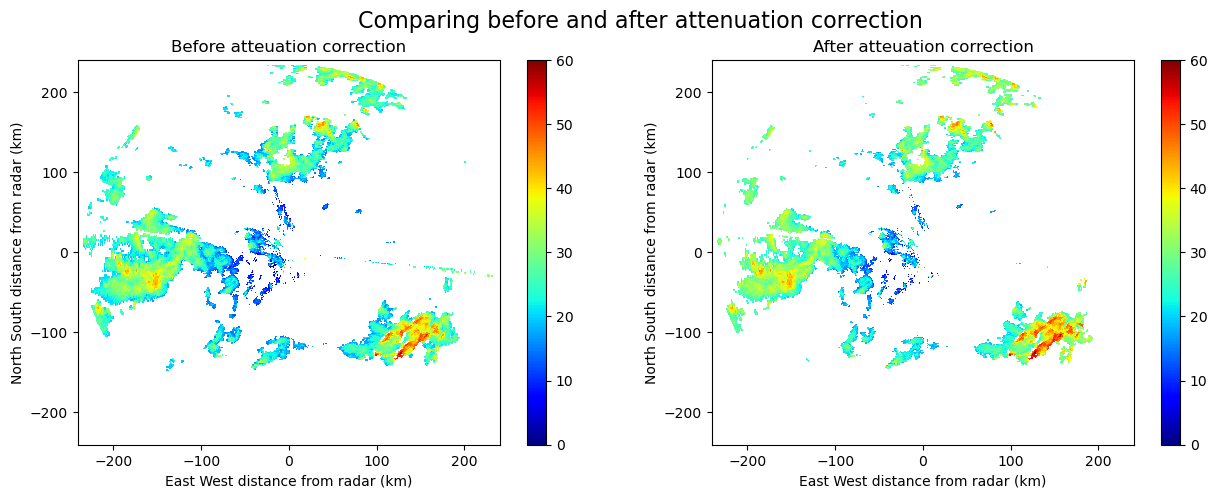

In [15]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('filtered_reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', 
                 title='Before atteuation correction')
                 #title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('corrected_filtered_reflectivity', 0, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', ax=ax2, #gatefilter=gtfilter,
                 title='After atteuation correction')

plt.suptitle('Comparing before and after attenuation correction', fontsize=16)
plt.show()

* เห็นได้ชัดเจนว่า ค่าการสะท้อนที่ก่อนปรับแก้ กับ หลังปรับแก้ attenuation มีความแตกต่างกันชัดเจน แล้ว flare หายไปด้วยหลังจากมีการปรับแก้

In [16]:
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'signal_to_noise_ratio', 'reflectivity_copy', 'filtered_reflectivity', 'normalized_coherent_power', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_filtered_reflectivity'])


## พลอตภาพผลลัพธ์การปรับแก้ และค่าตามแนวรัศมีการกวาดเลือก ray ที่ต้องการวิเคราะห์
* โค้ดจาก https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html

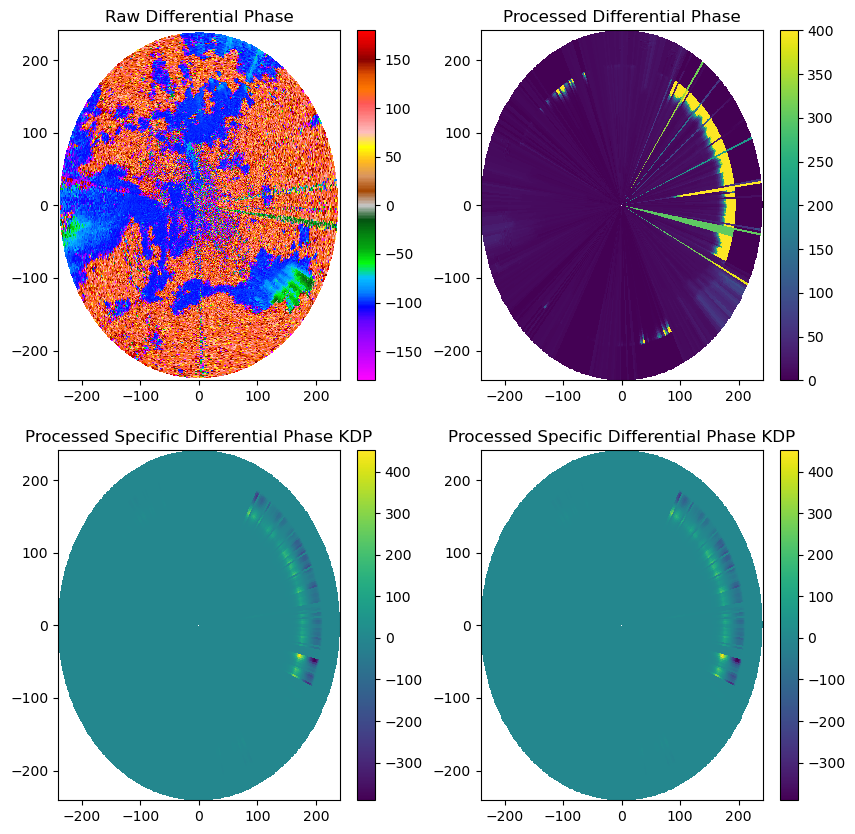

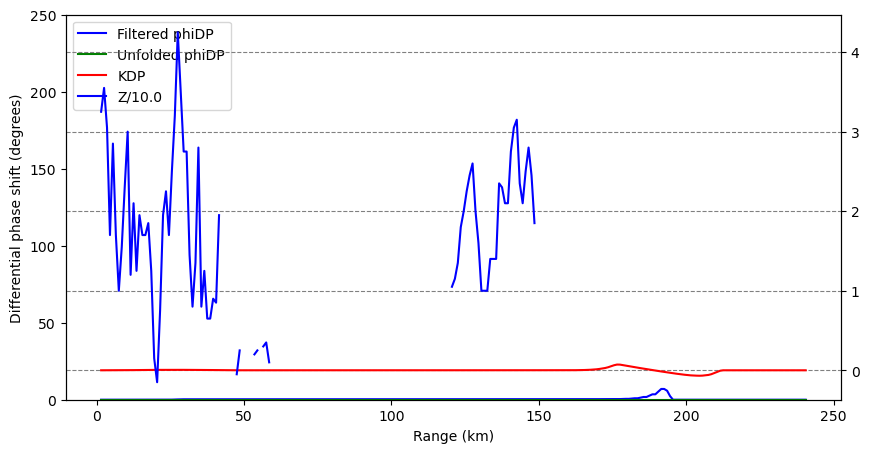

In [17]:
# create a plot of the various differential phase fields
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
display.plot_ppi('differential_phase', 0, ax=ax1,
                 title='Raw Differential Phase', colorbar_label='',
                 axislabels_flag=False)

ax2 = fig.add_subplot(222)
display.plot_ppi('proc_dp_phase_shift', 0, ax=ax2,
                 title='Processed Differential Phase', colorbar_label='',
                 axislabels_flag=False)

ax3 = fig.add_subplot(223)
display.plot_ppi('recalculated_diff_phase', 0, ax=ax3,
                 title='Processed Specific Differential Phase KDP', colorbar_label='',
                 axislabels_flag=False)

ax4 = fig.add_subplot(224)
display.plot_ppi('recalculated_diff_phase', 0, ax=ax4,
                 title='Processed Specific Differential Phase KDP',
                 colorbar_label='',
                 axislabels_flag=False)
plt.show()

# plot a fields from a single ray
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
ray_num = 225

# filtered phidp and unfolded phidp
display.plot_ray('proc_dp_phase_shift', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax)

display.plot_ray('unfolded_differential_phase', ray_num, format_str='g-',
                 axislabels_flag=False, title_flag=False, ax=ax)

# set labels
ax.set_ylim(0, 250)
ax.set_ylabel('Differential phase shift (degrees)')
ax.set_xlabel('Range (km)')

# plot KDP and reflectivity on second axis
ax2 = ax.twinx()
display.plot_ray('recalculated_diff_phase', ray_num, format_str='r-',
                 axislabels_flag=False, title_flag=False, ax=ax2)
radar.add_field_like('reflectivity', 'scaled_reflectivity',
                     radar.fields['reflectivity']['data']/10.)
display.plot_ray('scaled_reflectivity', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax2)

# decorate
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(display.plots,
          ["Filtered phiDP", "Unfolded phiDP", 'KDP', 'Z/10.0'],
          loc='upper left')
plt.show()

# Gridding PPI to cartesian

In [18]:
#radar_p=radar.extract_sweeps([0]) # เลือกมุมยก 0 คือ มุมแรก
lat_0 = radar.latitude['data'][0]
lon_0 = radar.longitude['data'][0]

shape = (11, 241, 241)
grid = pyart.map.grid_from_radars(
            radar,
            gatefilter=gtfilter,
            grid_shape=shape, #Number of points in the grid (z, y, x)
            grid_limits=((0, 10000), (-240000, 240000), (-240000, 240000)),    # ตั้งค่า(2000, 2000) หมายความว่าต้องการให้สร้างกริด cappi ที่ระดับ 2 km จาก ppi ดังกล่าว
            grid_origin = (lat_0,lon_0),
            fields=['corrected_filtered_reflectivity'],
            #roi_func= 'constant', constant_roi=4000.0 # เปลี่ยนฟังก์ชั่นเป็น roi_func= 'constant' เพื่อต้องการให้ดึงขัอมูลจุดของมุม ppi ที่อยู่ในระดับสูงมาคิดน้ำหนักด้วย สังเกตตรงกลางสถานีจะมีค่าฝนแล้ว
)

C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\graph\gridmapdisplay.py:213: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


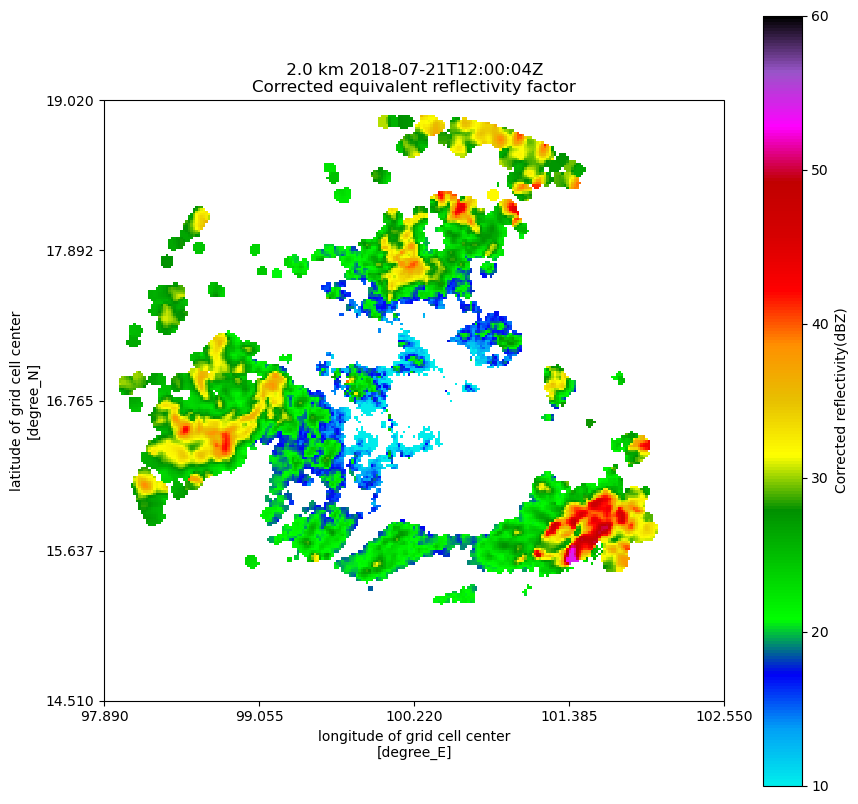

In [19]:
fig = plt.figure(figsize=[10, 10])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid("corrected_filtered_reflectivity", level=2, cmap=pyart.graph.cm.NWSRef, vmin=10, vmax=60)

# ส่งออกผลลัพธ์ CAPPI ไปเป็น geotiff นำไปใช้ใน qgis


In [20]:
pyart.io.write_grid_geotiff(grid, './0results/filtered_atten_dbz_CAPPI2km_phs.tif', 'corrected_filtered_reflectivity', 
                            rgb=False, level=2, warp=True, sld=False, use_doublequotes=True)

RuntimeError: Attempt to create new tiff file `./0results/filtered_atten_dbz_CAPPI2km_phs.tif' failed: No such file or directory

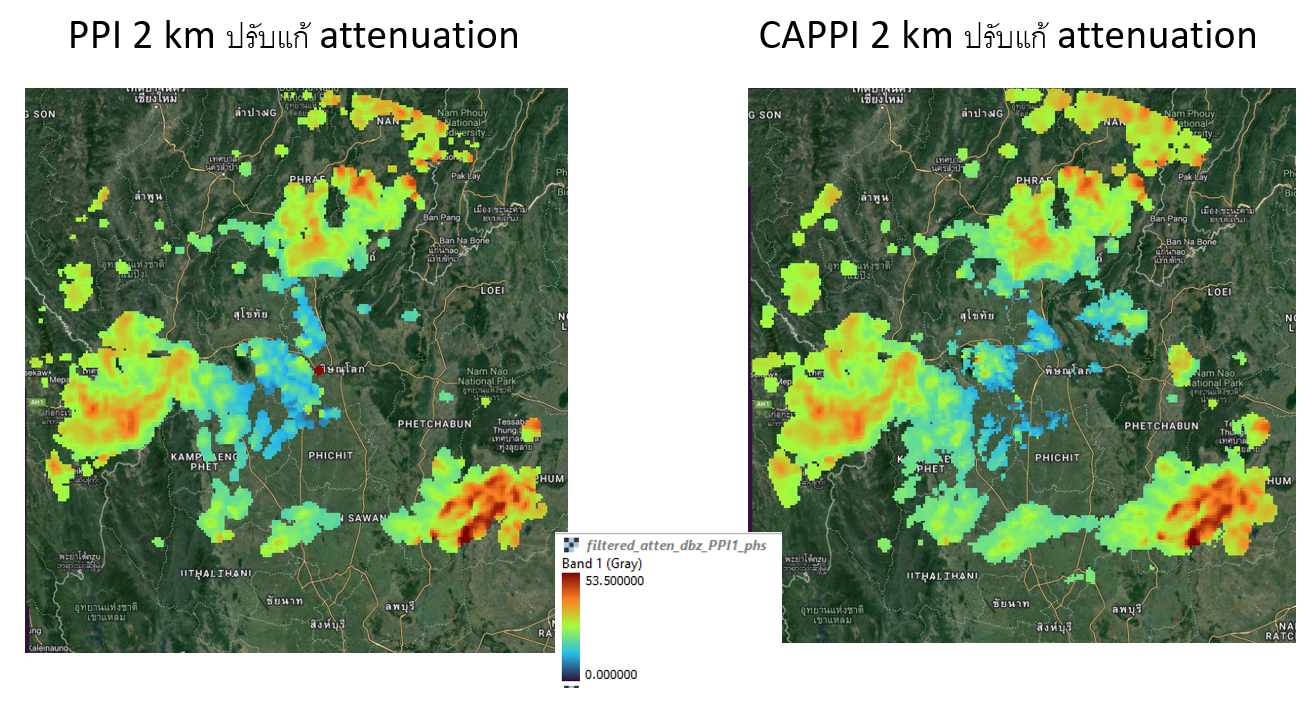

# ทำโค้ดต่อ
* หาค่า max dbz ppi กับ cappi ในหนึ่งชั่วโมง
* ทำโค้ดให้รันแบบ batch ทั้ง ppi กับ cappi 